In [1]:
import os
import sys
sys.path.append('/home/haselab/projects/sakai/AnoMAR/src')
import yaml

from datasets import build_dataset, build_transforms
from denoiser import get_denoiser
from models import create_vae

import matplotlib.pyplot as plt
import numpy as np

/home/haselab/anaconda3/envs/anomar/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
from torch.utils.data import DataLoader
import torch

dataset = build_dataset(
    dataset_name='mvtec_ad',
    data_root = "data/mvtec_ad",
    train=False,
    img_size=224,
    transform_type="default",
    category = "bottle",
    anom_only = True
)
print(len(dataset))
bs = 4
dataloader = DataLoader(dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=False)

batch = list(dataloader)[-2]
samples = batch["samples"].to("cuda")
samples.shape

63


torch.Size([4, 3, 224, 224])

In [28]:

config_path = "/home/haselab/projects/sakai/AnoMAR/ad_dit_d8w768/config.yaml"
ckpt_path = "/home/haselab/projects/sakai/AnoMAR/ad_dit_d8w768/model_latest.pth"


with open(config_path, "r") as f:
    config = yaml.safe_load(f)
    
vae = create_vae(**config["vae"])
vae = vae.cuda()
vae.eval()
vae_embed_dim = config['vae']['embed_dim']
vae_stride = config['vae']['stride']
img_size = config['data']['img_size']
diff_in_sh = (vae_embed_dim, img_size // vae_stride, img_size // vae_stride)

denoiser = get_denoiser(**config['diffusion'], input_shape=diff_in_sh)
denoiser.load_state_dict(torch.load(ckpt_path, weights_only=True, map_location="cpu"))
denoiser.cuda()
denoiser.eval()

Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
Loading pre-trained KL-VAE
Missing keys:
[]
Unexpected keys:
[]
Restored from ./weights/vae/kl16.ckpt


Denoiser(
  (clas_embed): Embedding(15, 768)
  (net): DiT(
    (x_embedder): PatchEmbed(
      (proj): Conv2d(16, 768, kernel_size=(2, 2), stride=(2, 2))
      (norm): Identity()
    )
    (t_embedder): TimestepEmbedder(
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=768, bias=True)
        (1): SiLU()
        (2): Linear(in_features=768, out_features=768, bias=True)
      )
    )
    (y_embedder): LabelEmbedder(
      (embedding_table): Embedding(15, 768)
    )
    (blocks): ModuleList(
      (0-7): 8 x DiTBlock(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (norm2): LayerNorm((768,)

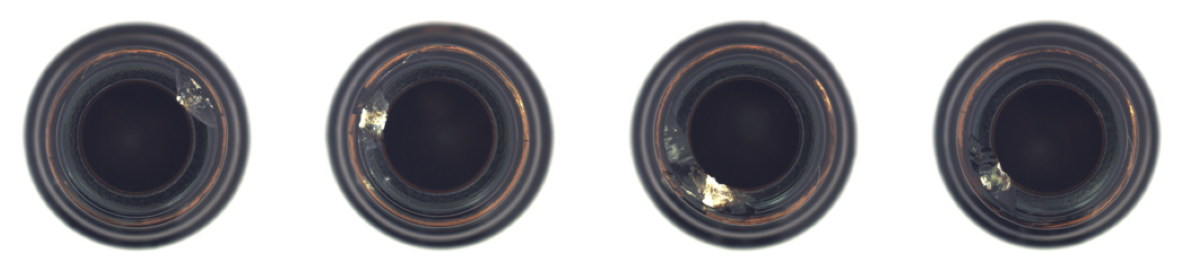

In [29]:
def denormalize(x):
    # [-1, 1] => [0, 1]
    return x / 2 + 0.5

anomaly_images = batch["samples"].permute(0, 2, 3, 1).cpu().numpy()
anomaly_samples = denormalize(anomaly_images)

fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axs[i].imshow(anomaly_samples[i])
    axs[i].axis("off")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46616328..1.699146].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0065506..2.1444697].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4201688..2.545783].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5930266..2.5961356].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5064708..1.6565883].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9630518..2.094317].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3573666.

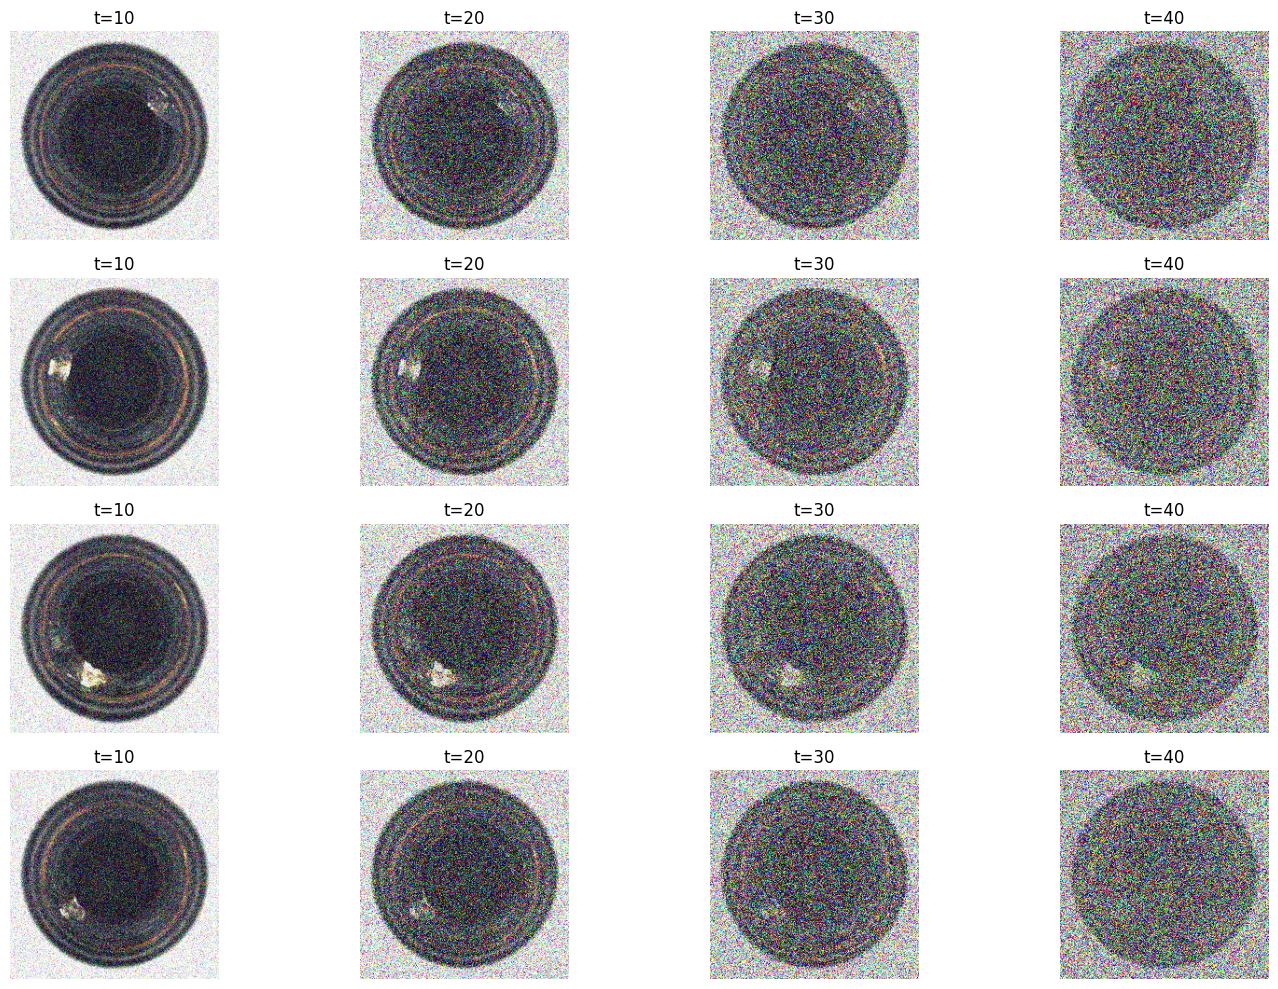

In [30]:
# add noise
x_t_list = []
t_range = [10, 20, 30, 40]
for t in t_range:
    x_t = denoiser.q_sample(samples, torch.tensor([t] * bs).cuda())
    x_t_list.append(x_t)

fig, ax = plt.subplots(4, 4, figsize=(15, 10))
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(denormalize(x_t_list[j][i].permute(1, 2, 0).cpu().numpy()))
        ax[i, j].axis("off")
        ax[i, j].set_title(f"t={t_range[j]}")
        
plt.tight_layout()
plt.show()

### Note: The denoised images show the loss of original information. But we acutually use the denoised vae latent. 

In [33]:
# get latent
with torch.no_grad():
    posterior = vae.encode(samples)
    z = posterior.sample().mul_(0.2325)
print(z.shape)

# add noise
t_idx = 0
t = torch.tensor([t_range[t_idx]] * bs).cuda()
labels = batch["labels"].cuda()
noised_latents = denoiser.q_sample(z, t)

# denoising
with torch.no_grad():
    denoised_latents = denoiser.denoise_from_intermediate(z, t, labels)
print(denoised_latents.shape)

torch.Size([4, 16, 14, 14])
torch.Size([4, 16, 14, 14])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46616328..1.699146].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.084510624..1.025171].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5064708..1.6565883].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.108029634..1.0257176].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4597528..1.6641865].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10157204..1.0270549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.52723

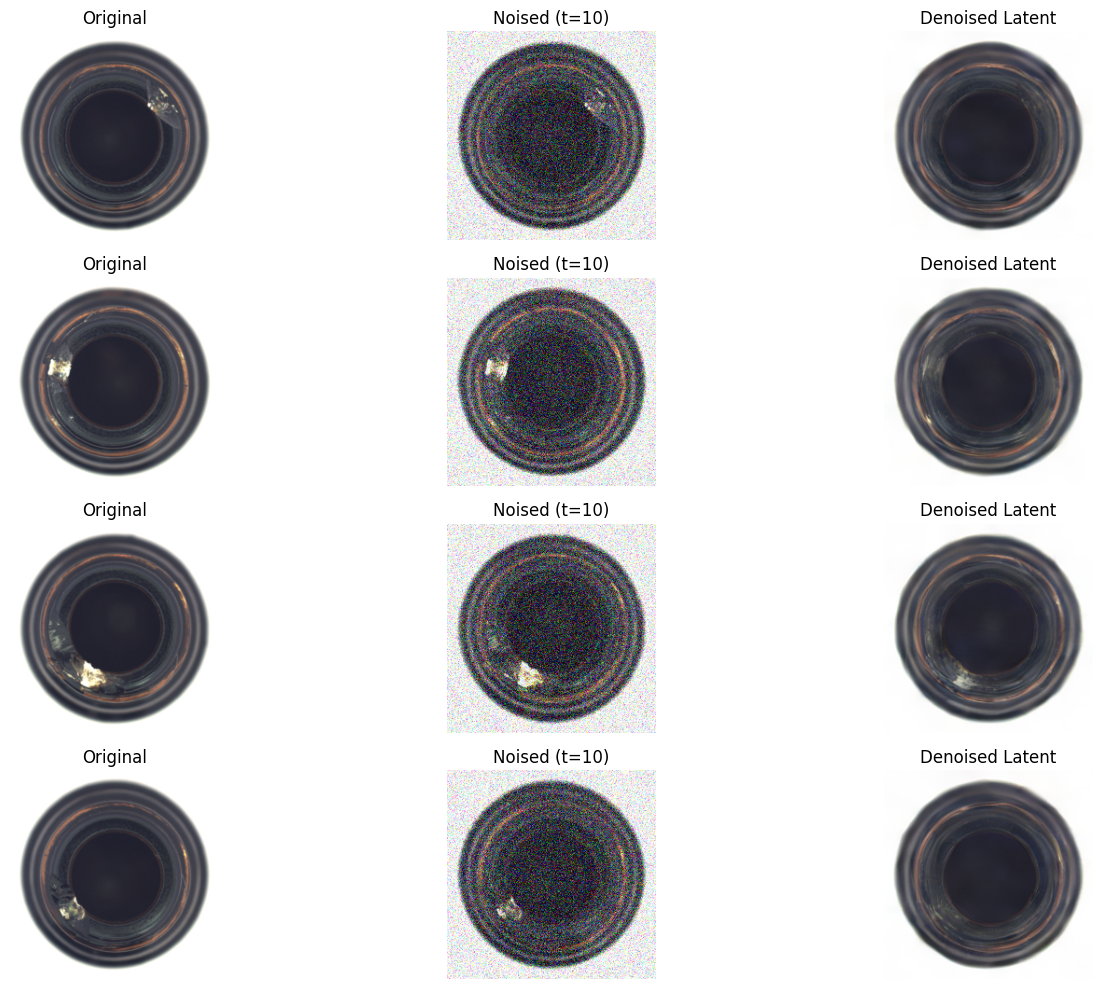

In [34]:
# visualize denoised latents

with torch.no_grad():
    x_reconst = vae.decode(denoised_latents / 0.2325).cpu()
x_reconst = denormalize(x_reconst.permute(0, 2, 3, 1).numpy())  

fig, ax = plt.subplots(4, 3, figsize=(15, 10))

for i in range(4):
    ax[i, 0].imshow(anomaly_samples[i])
    ax[i, 0].axis("off")
    ax[i, 0].set_title("Original")
    
    ax[i, 1].imshow(denormalize(x_t_list[t_idx][i].permute(1, 2, 0).cpu().numpy()))
    ax[i, 1].axis("off")
    ax[i, 1].set_title(f"Noised (t={t_range[t_idx]})")
    
    ax[i, 2].imshow(x_reconst[i])
    ax[i, 2].axis("off")
    ax[i, 2].set_title("Denoised Latent")
    
plt.tight_layout()
plt.show()